### Predicción del rendimiento estimado de computadoras (ERP) usando características de hardware

Descripción del problema:
Dado un conjunto de registros de computadores con características de hardware (tiempo de ciclo, memoria mínima/máxima, cache, número de canales y medidas de rendimiento publicadas), se busca construir un modelo de regresión supervisada que prediga la variable continua ERP (Estimated Relative Performance). El objetivo es minimizar errores absolutos/raíz cuadrática (MAE / RMSE) y obtener un modelo interpretable o explicable que permita entender qué atributos afectan más al rendimiento estimado.

Entradas (features):

- MYCT (machine cycle time, en nanosegundos)

- MMIN, MMAX (memoria mínima/máxima, KB)

- CACH (cache size, KB)

- CHMIN, CHMAX (canales mínimos/máximos)

- PRP (published relative performance) — se puede usar como feature o target alternativo

- VendorName (categórica; opcional convertir a dummies)

NOTA: ModelName suele ser casi única por fila y normalmente se descarta.

Salida (target):

- ERP (Estimated Relative Performance) — variable continua.

Tipo de problema: regresión supervisada (no series temporales).

Métricas recomendadas: RMSE, MAE, R².

Suposiciones:

Observaciones independientes.

Las medidas numéricas son representativas del rendimiento.

No hay dependencia temporal ni drift en las observaciones.

Limitaciones:

ERP es una estimación (no medición directa) y puede contener sesgos.

Modelos complejos (RandomForest, etc.) requieren técnicas de interpretación (SHAP/Permutation) para explicar contribuciones de features.

Algunas variables categóricas pueden no generalizar (p. ej. ModelName).

Decisiones de modelado sugeridas:

Escalar variables numéricas para modelos lineales / regularizados.

Comparar modelos lineales (Linear, Ridge, Lasso) con modelos no lineales (RandomForest).

Usar validación cruzada para comparar desempeño y evitar overfitting.

Considerar transformar target (log) si está fuertemente sesgado.

In [1]:
import pandas as pd 
import numpy as np

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data", header=None)
df.columns = ['vendor_name', 'model_name', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP']
df.head(20)

,vendor_name,model_name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132
5,amdahl,470v/b,26,8000,32000,64,8,32,318,290
6,amdahl,580-5840,23,16000,32000,64,16,32,367,381
7,amdahl,580-5850,23,16000,32000,64,16,32,489,381
8,amdahl,580-5860,23,16000,64000,64,16,32,636,749
9,amdahl,580-5880,23,32000,64000,128,32,64,1144,1238


In [2]:
df = df.drop(columns=['vendor_name', 'model_name', 'MYCT', 'PRP'])
df.head(20)

,MMIN,MMAX,CACH,CHMIN,CHMAX,ERP
0,256,6000,256,16,128,199
1,8000,32000,32,8,32,253
2,8000,32000,32,8,32,253
3,8000,32000,32,8,32,253
4,8000,16000,32,8,16,132
5,8000,32000,64,8,32,290
6,16000,32000,64,16,32,381
7,16000,32000,64,16,32,381
8,16000,64000,64,16,32,749
9,32000,64000,128,32,64,1238


In [3]:
# Analisis exploratorio del df
print("Dimensiones del dataset:", df.shape)
print("\nTipos de datos:\n", df.dtypes)
print("\nValores nulos por columna:\n", df.isnull().sum())
df.describe().T 

Dimensiones del dataset: (209, 6)

Tipos de datos:
 MMIN     int64
MMAX     int64
CACH     int64
CHMIN    int64
CHMAX    int64
ERP      int64
dtype: object

Valores nulos por columna:
 MMIN     0
MMAX     0
CACH     0
CHMIN    0
CHMAX    0
ERP      0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
MMIN,209.0,2867.980861,3878.742758,64.0,768.0,2000.0,4000.0,32000.0
MMAX,209.0,11796.153110,11726.564377,64.0,4000.0,8000.0,16000.0,64000.0
CACH,209.0,25.205742,40.628722,0.0,0.0,8.0,32.0,256.0
CHMIN,209.0,4.698565,6.816274,0.0,1.0,2.0,6.0,52.0
CHMAX,209.0,18.267943,25.997318,0.0,5.0,8.0,24.0,176.0
ERP,209.0,99.330144,154.757102,15.0,28.0,45.0,101.0,1238.0


<Axes: >

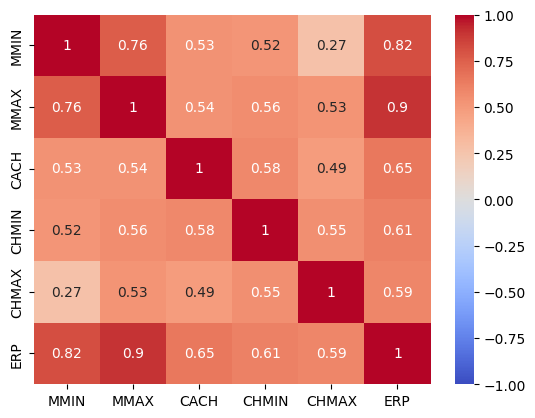

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

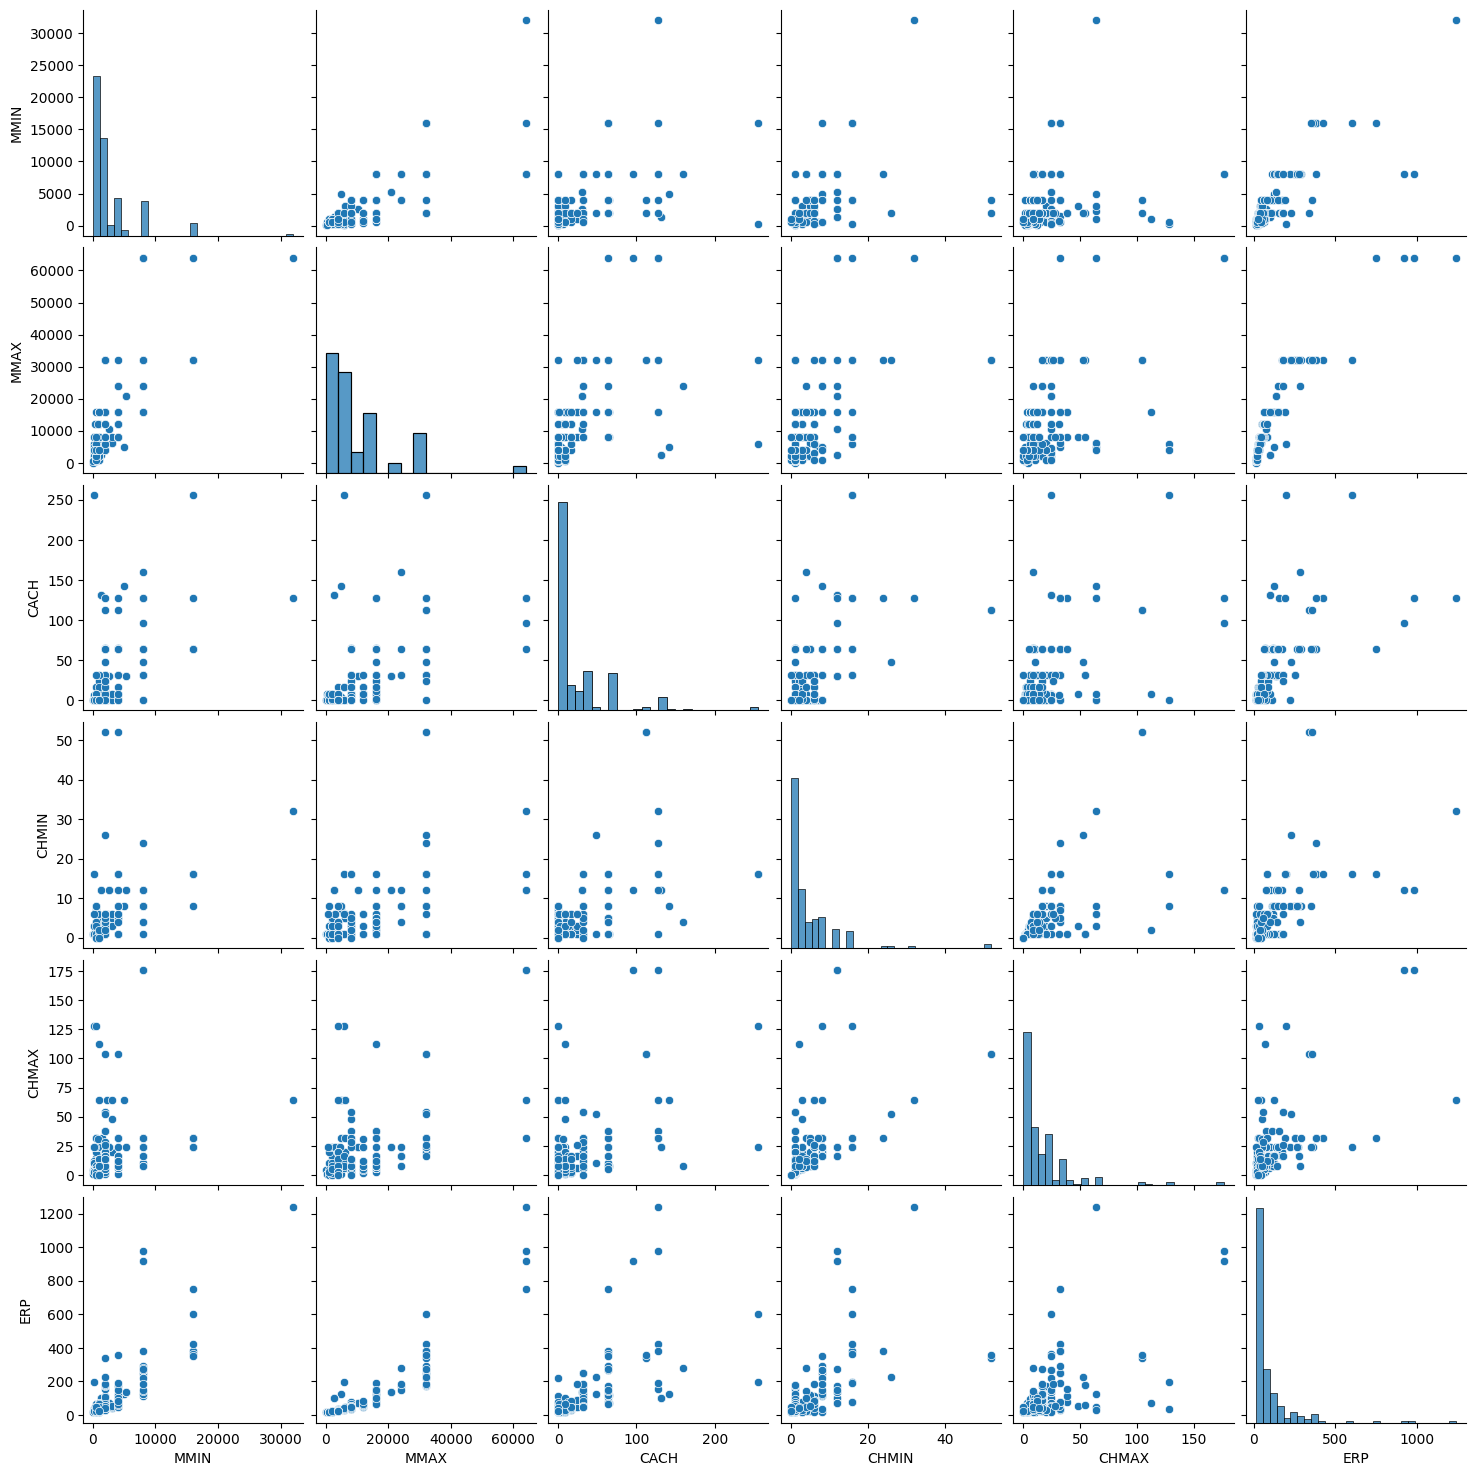

In [5]:
# analisis exploratorio del df
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(df.select_dtypes(include=[np.number]))
plt.show()

In [36]:
from sklearn.model_selection import train_test_split
x = df.drop(columns=['ERP'])
y = df['ERP']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [37]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
scaler_X = StandardScaler()
scaler_y = StandardScaler()
pt_x = PowerTransformer()
pt_y = PowerTransformer()
numeric_cols = x.columns
x_train_scaled = pd.DataFrame(scaler_X.fit_transform(x_train), columns=numeric_cols)
y_train_scaled = pd.DataFrame(scaler_y.fit_transform(y_train.values.reshape(-1, 1)), columns=['ERP'])
x_train_transformed = pd.DataFrame(pt_x.fit_transform(x_train_scaled), columns=numeric_cols)
y_train_trasnformed = pd.DataFrame(pt_y.fit_transform(y_train_scaled), columns=['ERP'])
x_train_transformed.head(20)

,MMIN,MMAX,CACH,CHMIN,CHMAX
0,1.611540,0.859614,0.936079,1.265899,0.481027
1,2.000794,1.624255,1.481688,1.265899,0.953100
2,1.611540,2.259515,1.838931,1.577218,2.260990
3,-0.614126,-0.833818,-1.025131,0.192299,0.953100
4,2.000794,1.624255,2.043841,1.752674,0.953100
5,0.173363,-0.833818,-1.025131,0.543501,-0.331213
6,-0.614126,-1.314042,-1.025131,-0.848508,-0.745601
7,0.173363,-0.054695,-0.291152,-0.848508,-0.745601
8,-1.559016,-0.414596,-1.025131,-0.848508,0.125005
9,-1.111141,-1.314042,-0.291152,-0.848508,-0.745601


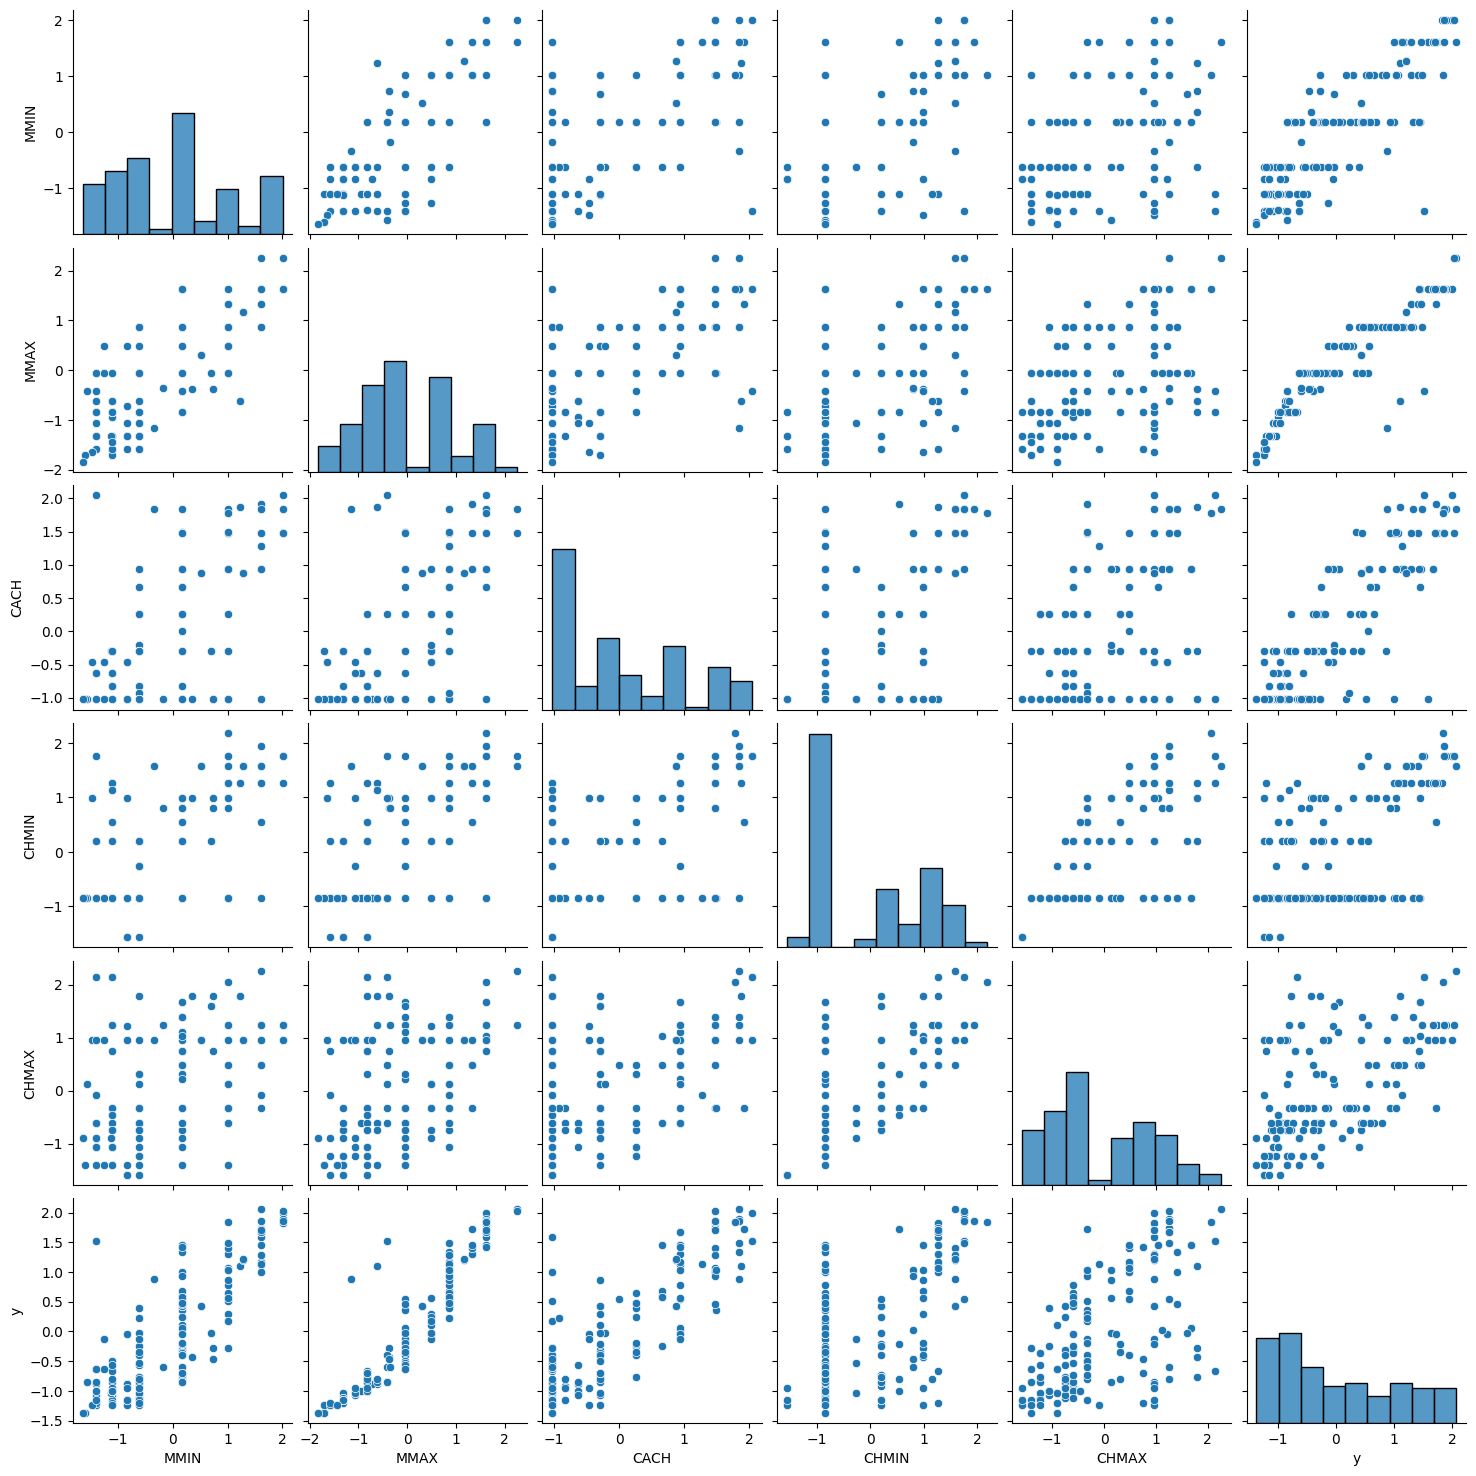

In [38]:
sns.pairplot(x_train_transformed.assign(y=y_train_trasnformed))
plt.show()

<Axes: >

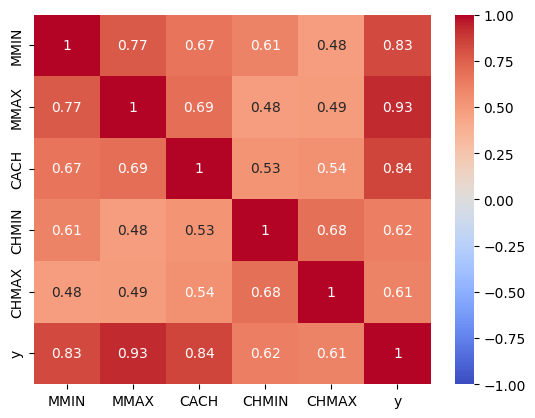

In [40]:
sns.heatmap(x_train_transformed.assign(y=y_train_trasnformed).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

In [26]:
# sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

## 3. Estructura del modelo para resolver el problema:
Una vez descrito el problema, debes proponer un modelo de la situación. La estructura de este modelo puede ser:

- Regresor lineal Bayesiano (problema de regresión).
- Regresor logístico Bayesiano (problema de clasificación).

Poner modelo

## 4. Definición del modelo (15 puntos)

A partir del análisis exploratorio de datos y con la estructura de modelo elegida, definir claramente:

1. Las entradas y salidas de su modelo.
2. Las limitaciones de este modelo (qué se modela y qué no se modela).
3. Suposiciones explícitas e implicitas en su modelo.
4. Definición del modelo en lenguaje probabilístico.

$$
\begin{align}
\begin{array}{lcl}
\text{ERP}_i & \sim & \text{Normal}(\mu_i, \sigma) \\

\mu_i & = & \alpha

+ \beta_\text{MMAX}(\text{MMAX\_st})
+ \beta_\text{CACH}(\text{CACH\_st})
+ \beta_\text{CHMIN}(\text{CHMIN\_st})

\\

\alpha & \sim & \text{Log-Normal}(0, 1) \\
\beta_\text{MMAX} & \sim & \text{Normal}(0, 1) \\
\beta_\text{CACH} & \sim & \text{Log-Normal}(0, 1) \\
\beta_\text{CHMIN} & \sim & \text{Log-Normal}(0, 1) \\
\sigma & \sim & \text{Half-Normal}(0, 1)
\end{array}
\end{align}
$$

Notas:

Para MMAX una distribución normal.

Para CACH podríamos usar una distribución log-normal y en caso de que no funcione incluso una exponencial.

Para CHMIN utilizaremos una log-normal pero...

In [29]:
# Validacion de simulaciones predictiva previa


## 5. Implementación del modelo en PyMC (20 puntos)

In [55]:
import pymc as pm
import arviz as az

In [69]:
x_train_transformed = x_train_transformed.drop(columns=['CHMAX', 'MMIN'])

In [70]:
MMAX = np.array(x_train_transformed['MMAX'].values)
CHMIN = np.array(x_train_transformed['CHMIN'].values)
CACH = np.array(x_train_transformed['CACH'].values)

In [71]:
import numpy as np

print("MMAX shape:", np.asarray(MMAX).shape)
print("CHMIN shape:", np.asarray(CHMIN).shape)
print("CACH shape:", np.asarray(CACH).ravel().shape)
print("x_train_transformed shape:", np.asarray(x_train_transformed).shape)

MMAX shape: (167,)
CHMIN shape: (167,)
CACH shape: (167,)
x_train_transformed shape: (167, 3)


In [75]:
cords = {
    'obs': np.arange(len(x_train_transformed))
}

In [78]:
with pm.Model(coords=cords) as model:
    
    mmax = pm.Data('MMAX', MMAX, dims='obs')
    chmin = pm.Data('CHMIN', CHMIN, dims='obs')
    cach = pm.Data('CACH', CACH, dims='obs')
    
    # Priors for unknown model parameters
    alpha = pm.LogNormal('alpha', mu=0, sigma=1)
    beta_MMAX = pm.Normal('beta_MMAX', mu=0, sigma=1)
    beta_CHMIN = pm.LogNormal('beta_CHMIN', mu=0, sigma=1)
    beta_CACH = pm.LogNormal('beta_CACH', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = pm.Deterministic(
          'mu',
          alpha + 
          beta_MMAX * mmax + 
          beta_CHMIN * chmin + 
          beta_CACH * cach)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=np.asarray(x_train_transformed))

    # Posterior predictive checks
    # ppc = pm.sample_posterior_predictive(pm.sample(1000, tune=1000), var_names=["Y_obs"])

In [80]:
with model:
    idata = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

Initializing NUTS using jitter+adapt_diag...


ValueError: operands could not be broadcast together with shapes (1,1) (1,1) (1,1) (167,3) (1,167) 
Apply node that caused the error: Composite{...}(Gt.0, Log.0, ExpandDims{axes=[0, 1]}.0, Y_obs{[[ 0.85961 ... 84850765]]}, Composite{(i0 + (i1 * i2) + (i3 * i4) + (i5 * i6))}.0)
Toposort index: 28
Inputs types: [TensorType(bool, shape=(1, 1)), TensorType(float64, shape=(1, 1)), TensorType(float64, shape=(1, 1)), TensorType(float64, shape=(167, 3)), TensorType(float64, shape=(1, None))]
Inputs shapes: [(1, 1), (1, 1), (1, 1), (167, 3), (1, 167)]
Inputs strides: [(1, 1), (8, 8), (8, 8), (8, 1336), (1336, 8)]
Inputs values: [array([[ True]]), array([[-0.75158745]]), array([[0.47161729]]), 'not shown', 'not shown']
Outputs clients: [[Sum{axes=None}(sigma > 0)], [Sum{axis=0}(Composite{...}.1)], [Sum{axes=None}(Composite{...}.2)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

## 6. Interpretación y Evaluación del modelo (20 puntos)

Debes interpretar los parámetros del modelo, e incluir gráficos para evaluar como los predictores afectan la variable de respuesta.

Debes de evaluar el modelo respecto a un conjunto de datos de validación y reportar qué tan bueno es tu modelo para la tarea que fue diseñado.